## Homework 06

### MACS 30100 Perspectives on Computational Modeling, Dr. Soltoff

Ellen Hsieh

18 Feb 2019

In [1]:
import random
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Conceptual exercises

#### a - b.

In [2]:
random.seed(123)

# Generate a data set with p=20 features, n=1000 observations
X = np.random.normal(0, 5, (1000, 20))
epsilon = np.random.normal(0, 1, 1000)

beta = np.array([random.randint(-5,5) for i in range(20)])
zero_ind = [random.randint(0, 19) for i in range(6)]
beta[zero_ind] = 0

Y = np.dot(X, beta) + epsilon

# Split the training and testing data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.1, random_state=124)

#### c.

In [3]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate AIC
    model = sm.OLS(y_train, x_train[:,feature_set])
    regr = model.fit()
    aic = regr.aic
    return regr, aic

In [4]:
# Subset selection process
all_features = list(range(20))
best_models = []
for i in range(1,21):
    model_lst = []
    count = 0
    for subset in itertools.combinations(all_features, i):
        count += 1
        if count > 200:
            continue
        result, aic = processSubset(subset)
        model_lst.append((result, aic, subset))
    best_models.append(sorted(model_lst, key=lambda x:x[1])[0])

In [5]:
# calcualte the training and testing MSE
train_mse = []
test_mse = []
for model in best_models:
    train_mse.append(mse(y_train, model[0].predict(x_train[:,model[2]])))
    test_mse.append(mse(y_test, model[0].predict(x_test[:,model[2]])))

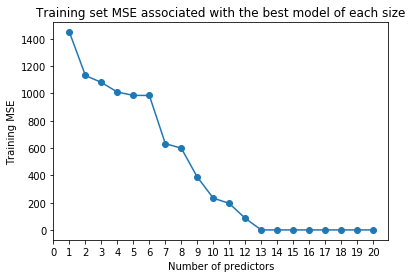

The training set MSE take on its minimum value at the model size 20


In [6]:
# plot the training MSE associated with the best model of each size
xrange = np.arange(1,21)
plt.plot(xrange, train_mse, marker='o')
plt.title('Training set MSE associated with the best model of each size')
plt.xlabel('Number of predictors')
plt.ylabel('Training MSE')
plt.xticks(np.arange(0, 21, 1))
plt.show()
print('The training set MSE take on its minimum value at the model size {}'.format(np.argmin(train_mse) + 1))

#### d - e.

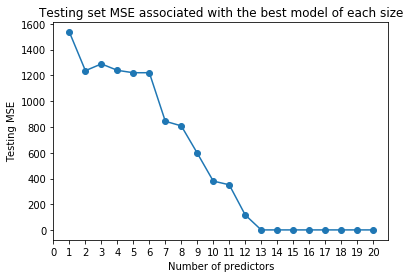

The testing set MSE take on its minimum value at the model size 13


In [7]:
# plot the testing MSE associated with the best model of each size
plt.plot(xrange, test_mse, marker='o')
plt.title('Testing set MSE associated with the best model of each size')
plt.xlabel('Number of predictors')
plt.ylabel('Testing MSE')
plt.xticks(np.arange(0, 21, 1))
plt.show()
print('The testing set MSE take on its minimum value at the model size {}'.format(np.argmin(test_mse) + 1))

The best model selects all the true predictors.

#### f.

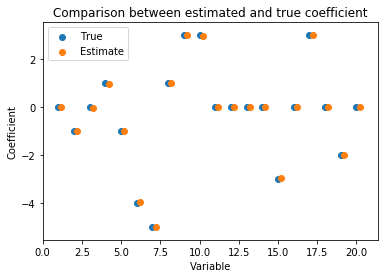

In [8]:
# calculate the coefficient for the estimated variables
estimates = np.zeros(20)
best_model = best_models[np.argmin(test_mse)]
for i, param in enumerate(best_model[2]):
    estimates[param] = (best_model[0].params)[i]

# plot the comparasion between estimated and true coefficient
plt.scatter(xrange, beta, label='True')
plt.scatter(xrange+0.2, estimates, label='Estimate')
plt.title('Comparison between estimated and true coefficient')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.legend()
plt.show()

#### g.

In [9]:
# caculate the coefficient errors for different best models according to the number of preditors
coef_errors = []
for r in range(20):
    estimates = np.zeros(20)
    for i, param in enumerate(best_models[r][2]):
        estimates[param] = best_models[r][0].params[i]
    coef_errors.append(np.sqrt(np.sum((beta - estimates) ** 2)))

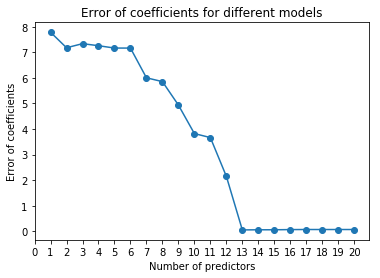

In [10]:
# plot the coefficient errors
plt.plot(xrange, coef_errors, marker='o')
plt.xlabel('Number of predictors')
plt.ylabel('Error of coefficients')
plt.title('Error of coefficients for different models')
plt.xticks(np.arange(21))
plt.show()

The curve and the trend of coefficient error plot is very similar to the test MSE plot from (d).

## Application exercises

In [11]:
# load the data
gss_train = pd.read_csv('./data/gss_train.csv')
gss_test = pd.read_csv('./data/gss_test.csv')

# split the train and test data
x_train = gss_train.drop(['egalit_scale'], axis=1)
y_train = gss_train[['egalit_scale']]
x_test = gss_test.drop(['egalit_scale'], axis=1)
y_test = gss_test[['egalit_scale']]

#### 1.

In [12]:
# fit a linear model using least squares on the training set
reg = LinearRegression().fit(x_train, y_train)
pred= reg.predict(x_test)
reg_mse = mse(y_test, pred)
print('The test MSE of linear regression model is {:.3f}'.format(reg_mse))

The test MSE of linear regression model is 63.214


#### 2.

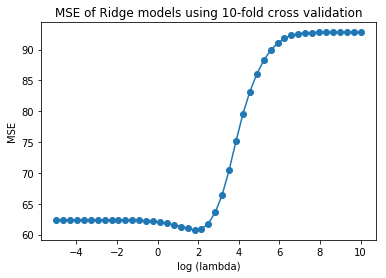

In [13]:
# fit a ridge model and get the MSE
lambdas = np.logspace(-5, 10, 45)
ridge_lst = []
for l in lambdas:
    ridge = Ridge(alpha=l).fit(x_train, y_train)
    ridge_lst.append(-(cross_val_score(ridge, x_train, y_train, cv=KFold(10), 
                                      scoring='neg_mean_squared_error')).mean())
    
# plot the MSE of teh ridge model 
plt.plot(np.log10(lambdas), ridge_lst,  marker='o')
plt.xlabel('log (lambda)')
plt.ylabel('MSE')
plt.title('MSE of Ridge models using 10-fold cross validation')
plt.show()

In [14]:
# calculate the test MSE of the best Ridge model
from sklearn.linear_model import RidgeCV
best_ridge = RidgeCV(alphas=lambdas, cv=10).fit(x_train, y_train)
best_ridge_mse = mse(y_test, best_ridge.predict(x_test))
print('The test MSE of the ridge model is {:.3f}'.format(best_ridge_mse))

The test MSE of the ridge model is 62.143


#### 3.

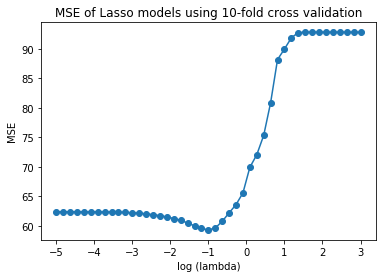

In [15]:
# fit a Lasso model and get the MSE
lambdas = np.logspace(-5, 3, 45)
lasso_lst = []
for l in lambdas:
    lasso = Lasso(alpha=l).fit(x_train, y_train)
    lasso_lst.append(-(cross_val_score(lasso, x_train, y_train, cv=KFold(10), 
                                       scoring='neg_mean_squared_error')).mean())

# plot the MSE of teh Lasso model 
plt.plot(np.log10(lambdas), lasso_lst,  marker='o')
plt.xlabel('log (lambda)')
plt.ylabel('MSE')
plt.title('MSE of Lasso models using 10-fold cross validation')
plt.show()

In [16]:
# calculate the test MSE of the best Lasso model
from sklearn.linear_model import LassoCV
best_lasso = LassoCV(alphas=lambdas, cv=10).fit(x_train, y_train)
best_lasso_mse = mse(y_test, best_lasso.predict(x_test))
print('The test MSE of the lasso model is {:.3f}'.format(best_lasso_mse))
print('The number of non-zero coefficient estimates of the best Lasso model is {}'.format(np.sum(best_lasso.coef_ != 0)))

The test MSE of the lasso model is 62.778
The number of non-zero coefficient estimates of the best Lasso model is 24


#### 4.

In [17]:
# fit and get the ElasticNet models
lambdas = np.logspace(-1, 4, 30)
elasticnet_lst = []
alphas = np.arange(0,1.1,0.1)
for a in alphas:
    elastic_temp_lst = []
    for l in lambdas:
        elastic = ElasticNet(alpha=l,l1_ratio=a).fit(x_train, y_train)
        elastic_temp_lst.append(-(cross_val_score(elastic, x_train, y_train, cv=KFold(10), 
                                      scoring='neg_mean_squared_error')).mean())
    temp_best_elastic = elastic_temp_lst[np.argmin(elastic_temp_lst)]
    elasticnet_lst.append(temp_best_elastic)

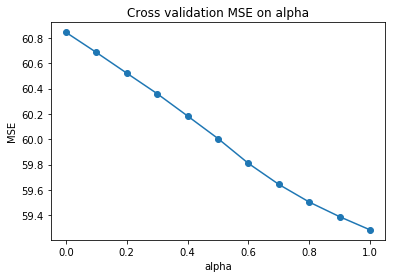

In [18]:
# plot the cross validation MSE on alpha
plt.plot(alphas, elasticnet_lst, marker='o')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Cross validation MSE on alpha')
plt.show()

In [19]:
# calculate the MSE of the best ElasticNet model
from sklearn.linear_model import ElasticNetCV
best_elastic = ElasticNetCV(l1_ratio=alphas, alphas=lambdas, cv=10, random_state=0).fit(x_train, y_train)
best_elastic_mse = mse(y_test, best_elastic.predict(x_test))
print('The test MSE of the ElasticNet model is {:.3f}'.format(best_elastic_mse))
print('The number of non-zero coefficient estimates of the best ElasticNet model is {}'.format(np.sum(best_elastic.coef_ != 0)))

The test MSE of the ElasticNet model is 62.778
The number of non-zero coefficient estimates of the best ElasticNet model is 24


#### 5.

In [20]:
# keep only non-binary variables
variables = []
for col in gss_train.columns:
    if col == 'egalit_scale':
        continue
    if gss_train[col].nunique() > 2:
        variables.append(col)

x_train_nonbi = x_train[variables]
x_test_nonbi = x_test[variables]

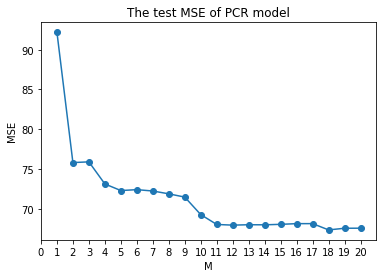

In [21]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# calcualte the MSE of PCR model
pcr_lst = []
for m in range(1,len(variables)+1):
    pca = PCA(m)
    x_reduced = pca.fit_transform(scale(x_train_nonbi))
    pcr_lst.append(-(cross_val_score(LinearRegression(), x_reduced, y_train, cv=KFold(10), 
                                     scoring='neg_mean_squared_error')).mean())

# plot the MSE of PCR
plt.plot(np.arange(1, len(variables)+1), pcr_lst, marker='o')
plt.title('The test MSE of PCR model')
plt.xlabel('M')
plt.ylabel('MSE')
plt.xticks(np.arange(21))
plt.show()

In [22]:
# get the best M of the PCR and its MSE
best_m = np.argmin(pcr_lst) +1
pca = PCA(best_m)
best_x_reduced = pca.fit_transform(scale(x_train_nonbi))
best_pcr = LinearRegression().fit(best_x_reduced, y_train)
best_pcr_mse = mse(y_test, best_pcr.predict(PCA(best_m).fit_transform(scale(x_test_nonbi))))
print('The best M is {}'.format(best_m))
print('The test MSE of PCR is {:.3f}'.format(best_pcr_mse))

The best M is 18
The test MSE of PCR is 76.441


#### 6.

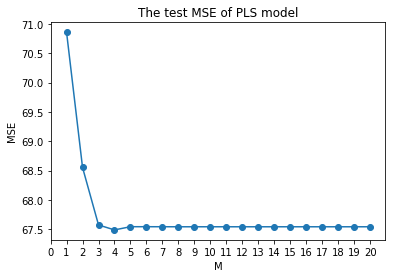

In [23]:
from sklearn.cross_decomposition import PLSRegression

# calcualte the MSE of PLS model
pls_lst = []
for m in range(1, len(variables) + 1):
    pls = PLSRegression(n_components=m)
    pls_lst.append(-(cross_val_score(pls, x_train_nonbi, y_train, cv=KFold(10), 
                                     scoring='neg_mean_squared_error')).mean())

# plot the MSE of PLS
plt.plot(np.arange(1, len(variables)+1), pls_lst, marker='o')
plt.title('The test MSE of PLS model')
plt.xlabel('M')
plt.ylabel('MSE')
plt.xticks(np.arange(21))
plt.show()

In [24]:
# get the best PLS model and its MSE
best_m = np.argmin(pls_lst)+1
best_pls = PLSRegression(n_components=best_m).fit(x_train_nonbi, y_train)
best_pls_mse = mse(y_test, best_pls.predict(x_test_nonbi))
print('The best M is {}'.format(best_m))
print('The test MSE of PLS is {:.3f}'.format(best_pls_mse))

The best M is 4
The test MSE of PLS is 71.977


#### 7.

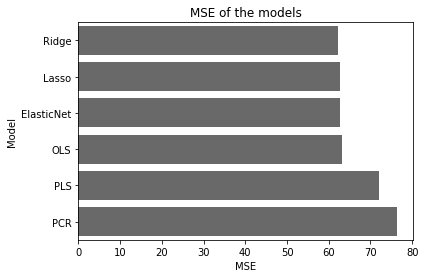

In [25]:
import seaborn as sns

# plot the comparison of different models
model_names=['OLS','Ridge','Lasso','ElasticNet','PCR','PLS']
mse_lst = [reg_mse, best_ridge_mse, best_lasso_mse, best_elastic_mse, best_pcr_mse, best_pls_mse]
mse_df = pd.DataFrame({'MSE': mse_lst, 'Model': model_names})
ax = sns.barplot(x="MSE", y="Model", data=mse_df.sort_values(by=['MSE']), color='dimgrey')
plt.title('MSE of the models')
plt.show()

The most accurate model is Ridge model, which has the samllest MSE. However, ElasticNet, Lasso, and OLS actually share the similar MSE with Ridge. As for PLS and PCR, their MSE are significantly larger than the other four models.